# Traffic Accidents Analysis

In [ ]:
import pandas as pd
from utils import utils
import config
import requests
import json
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import datetime as dt
from datetime import date
import numpy as np
from geopy.geocoders import Nominatim
import time
import openmeteo_requests
import requests_cache
from retry_requests import retry

In [2]:
# Settings to view dataframes
pd.set_option('display.max_columns', None) 

census_key = config.census_api_key

In [ ]:
# Filtering out data to only show California 
accident_df_raw = pd.read_csv('US_Accidents_March23.csv')
accident_df_clean = accident_df_raw[[
    'ID',
    'Severity',
    'Start_Time',
    'End_Time',
    'Start_Lat',
    'End_Lat',
    'City',
    'County',
    'State',
    'Zipcode',
    'Temperature(F)',
    'Wind_Chill(F)',
    'Visibility(mi)',
    'Precipitation(in)',
    'Weather_Condition'
]].query(' State == "CA" ')

accident_df_clean.to_csv('US_Accidents_March23_clean.csv', index = False)

In [3]:
accident_df_clean = pd.read_csv('data/accidents/US_Accidents_March23_clean.csv')

accident_df_clean.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,End_Lat,City,County,State,Zipcode,Temperature(F),Wind_Chill(F),Visibility(mi),Precipitation(in),Weather_Condition
0,A-729,3,2016-06-21 10:34:40,2016-06-21 11:04:40,38.085300,NaN,Vallejo,Solano,CA,94591,75.0,NaN,10.0,NaN,Clear
1,A-730,3,2016-06-21 10:30:16,2016-06-21 11:16:39,37.631813,NaN,Hayward,Alameda,CA,94544,75.0,NaN,10.0,NaN,Clear
2,A-731,2,2016-06-21 10:49:14,2016-06-21 11:19:14,37.896564,NaN,Walnut Creek,Contra Costa,CA,94595,82.9,NaN,10.0,NaN,Clear
3,A-732,3,2016-06-21 10:41:42,2016-06-21 11:11:42,37.334255,NaN,Cupertino,Santa Clara,CA,95014,75.9,NaN,10.0,NaN,Clear
4,A-733,2,2016-06-21 10:16:26,2016-06-21 11:04:16,37.250729,NaN,San Jose,Santa Clara,CA,95118,75.2,NaN,10.0,NaN,Clear


### Creating variable dataframe from txt file

In [ ]:
# Using a text file for the American Community Survey (ACS) variables to contain column data
txt_file = open('data/acs survey/Raw Variable List/acs_transportation_variables.txt', 'r')

# Initialize empty lists to contain dataframes
variable_list = []
dataframe_list = []

for line_file in txt_file:
    variable_list.append(line_file)


for variables in variable_list:
    # Check if line ends with a new line character
    if '\n' in variables:
        variable = variables[:-1] # Remove the new line character 
        variable = variable.split(', ') # Splitting variable by a comma separator
        variable_df = pd.DataFrame(variable).T # Pivot or transpose dataframe to row data
        dataframe_list.append(variable_df)
    else:
        variable = variables.split(', ')
        variable_df = pd.DataFrame(variable).T
        dataframe_list.append(variable_df)
    
variable_df = pd.concat(dataframe_list)
variable_df.rename(columns = {0: 'Variable_name', 1: 'Data_description'}, inplace = True)
variable_df.reset_index(inplace = True)
variable_df.drop('index', axis = 1, inplace = True)

variable_df.to_csv('data/acs survey/acs_variable_df.csv', index = False)

### ACS api call for loop

In [ ]:
# Initialize a list of years for loop
year_list = pd.Series(range(2011,2023)).to_list()
# Initialize string of variable names, separted by a comma
variable_df_list = ','.join(variable_df['Variable_name'].to_list())

data_df_list = []
error_year_list = []

# Looping over multiple years and retrieving the data from variable list for each year 
for year in year_list:
    try:
        url = f'https://api.census.gov/data/{year}/acs/acs5?get={variable_df_list}&for=zip%20code%20tabulation%20area:*&key={census_key}'
        data = requests.get(url)
        data_json = data.json()
        data_df = pd.DataFrame(data_json)
        data_df.columns = data_df.iloc[0]
        data_df.drop(data_df.index[0], inplace = True)
        data_df['year'] = year
        data_df_list.append(data_df)
    except:
        error_year_list.append(year)

# Print any year that wasn't called in the api
print(error_year_list)

acs_df = pd.concat(data_df_list)

# Cleaning ACS survey dataframe
cols_move = ['year', 'zip code tabulation area']
acs_df = acs_df[ cols_move + [ col for col in acs_df.columns if col not in cols_move ] ]

acs_df.rename(columns = {'zip code tabulation area': 'zcta'}, inplace = True)
acs_df = acs_df.query(' state == "06" ')
acs_df = acs_df.drop('state', axis = 1)

acs_df.to_csv('data/acs survey/acs_survey.csv', index = False)

[]


In [5]:
acs_df = pd.read_csv('data/acs survey/acs_survey.csv')

### Combining zcta / zipcode data with accidents on zipcode column

In [ ]:
zip_zcta_df = pd.read_csv('data/zcta_zipcode/zip_zcta_xref.csv', usecols = ['zip_code', 'zcta'], keep_default_na = False, na_filter = False)
zip_zcta_df['zip_code'] = zip_zcta_df['zip_code'].replace('', 0).astype(str)

# Joining zip code data to the dataframe with accidents
zip_accident_df = pd.merge(zip_zcta_df, accident_df_clean, left_on = 'zip_code', right_on = 'Zipcode', how = 'inner')

In [ ]:
# Creating time columns - Year, Month, Day, Hour
zip_accident_df[['Date', 'Hour_Time_Raw']] = zip_accident_df['Start_Time'].str.split(' ', expand = True)
zip_accident_df[['Hour_Time', 'Useless_Col_1', 'Useless_Col_2']] = zip_accident_df['Hour_Time_Raw'].str.split(':', expand = True)
zip_accident_df[['Year', 'Month', 'Day']] = zip_accident_df['Date'].str.split('-', expand = True)

zip_accident_df.head()

,zip_code,zcta,ID,Severity,Start_Time,End_Time,Start_Lat,End_Lat,City,County,State,Zipcode,Temperature(F),Wind_Chill(F),Visibility(mi),Precipitation(in),Weather_Condition,Date,Hour_Time_Raw,Hour_Time,Useless_Col_1,Useless_Col_2,Year,Month,Day
0,94501,94501,A-338124,2,2017-02-24 20:24:56,2017-02-24 20:54:35,37.750423,NaN,Alameda,Alameda,CA,94501,50.0,NaN,10.0,NaN,Scattered Clouds,2017-02-24,20:24:56,20,24,56,2017,02,24
1,94501,94501,A-2646256,2,2018-08-14 13:00:35,2018-08-14 13:30:35,37.784531,NaN,Alameda,Alameda,CA,94501,62.1,NaN,10.0,NaN,Overcast,2018-08-14,13:00:35,13,00,35,2018,08,14
2,94501,94501,A-2699280,2,2018-07-11 11:33:50,2018-07-11 12:03:06,37.788097,NaN,Alameda,Alameda,CA,94501,68.0,NaN,10.0,NaN,Partly Cloudy,2018-07-11,11:33:50,11,33,50,2018,07,11
3,94501,94501,A-3802050,2,2023-02-12 17:58:00,2023-02-12 20:21:56,37.766476,37.765966,Alameda,Alameda,CA,94501,57.0,57.0,10.0,0.0,Fair,2023-02-12,17:58:00,17,58,00,2023,02,12
4,94501,94501,A-4053581,2,2022-05-18 08:28:00,2022-05-18 10:41:13,37.764774,37.765049,Alameda,Alameda,CA,94501,57.0,57.0,10.0,0.0,Fair,2022-05-18,08:28:00,08,28,00,2022,05,18


## Graphing

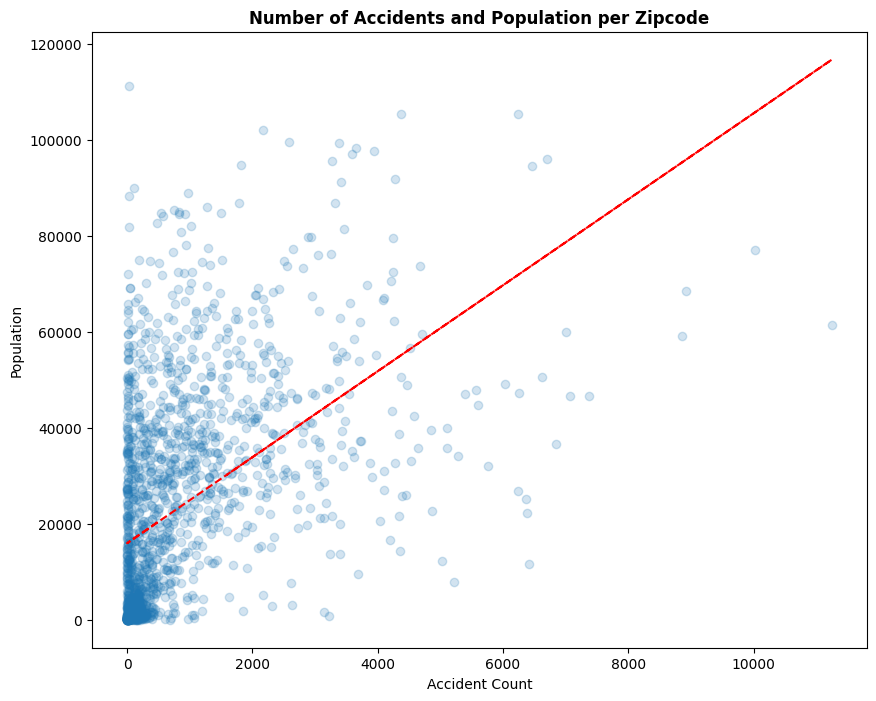

In [9]:
cnt_accident_df = zip_accident_df.groupby(by = 'zcta')['ID'].count().reset_index().rename(columns = {'ID': 'cnt_accidents'})

scatter_acs = acs_df
scatter_acs['zcta'] = scatter_acs['zcta'].astype(str)

pop_df = scatter_acs[['year', 'zcta', 'B01001_001E']].query(' year == 2019 ').rename(columns = {'B01001_001E': 'pop'})
pop_df['pop'] = pd.to_numeric(pop_df['pop'], errors='coerce')

group_df = pd.merge(cnt_accident_df, pop_df, on = 'zcta')
x = group_df['cnt_accidents']
y = group_df['pop']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize = (10,8))
plt.plot(x, p(x), "r--")
plt.scatter(x, y, alpha = 0.2)
plt.title('Number of Accidents and Population per Zipcode', fontweight = 'bold')
plt.xlabel('Accident Count')
plt.ylabel('Population')

plt.show()

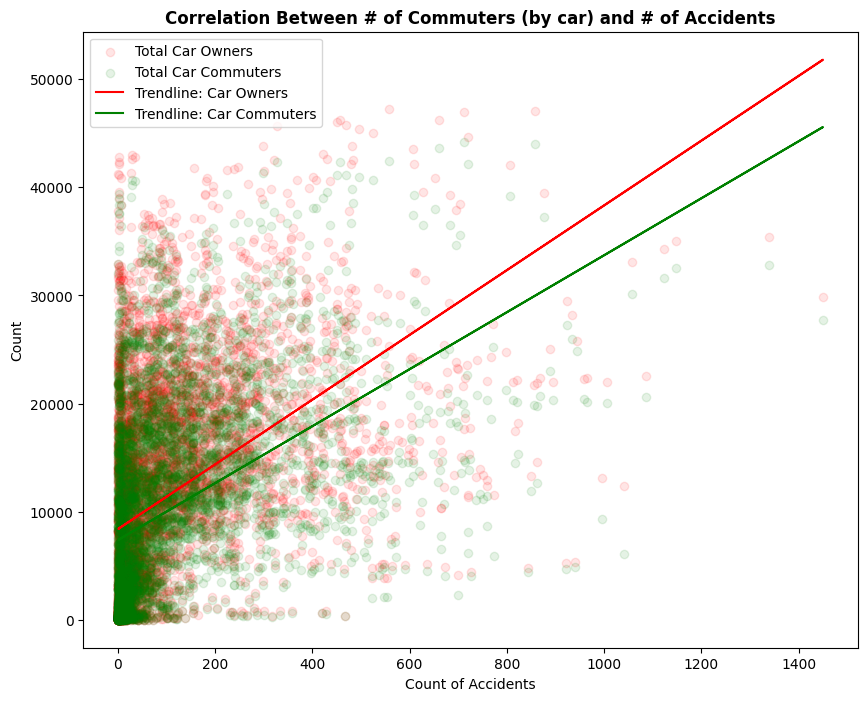

In [10]:
scatter_car_accident_df = zip_accident_df.groupby(by = ['zip_code', 'Year'])['ID'].count().reset_index().rename(columns = {'ID': 'cnt'})
scatter_car_accident_df['Year'] = scatter_car_accident_df['Year'].astype(int)

num_car_owners_variable = ['B08014_003E', 'B08014_004E', 'B08014_005E', 'B08014_006E', 'B08014_007E']
scatter_acs_df = acs_df[['year', 'zcta', 'B08006_002E'] + num_car_owners_variable]
scatter_acs_merge_df = scatter_acs_df.merge(zip_zcta_df, on = 'zcta')
scatter_acs_merge_df['total_car_owners'] = scatter_acs_merge_df[num_car_owners_variable].sum(axis = 1)

scatter_merge_df = scatter_acs_merge_df.merge(scatter_car_accident_df, left_on = ['year', 'zip_code'], right_on = ['Year', 'zip_code'])

x = scatter_merge_df['cnt']
y = scatter_merge_df['total_car_owners']
z = scatter_merge_df['B08006_002E']
xy = np.polyfit(x, y, 1)
xy_line = np.poly1d(xy)
xz = np.polyfit(x, z, 1)
xz_line = np.poly1d(xz)

plt.figure(figsize = (10,8))
plt.scatter(x, y, color='r', alpha=0.1, label='Total Car Owners')  
plt.scatter(x, z, color='g', alpha=0.1, label='Total Car Commuters') 
plt.plot(x, xy_line(x), "r", label='Trendline: Car Owners')  
plt.plot(x, xz_line(x), "g", label='Trendline: Car Commuters')  

plt.title('Correlation Between # of Commuters (by car) and # of Accidents', fontweight = 'bold')
plt.xlabel('Count of Accidents')
plt.ylabel('Count')
plt.legend()

plt.show()

The scatterplot shows a direct correlation between the population and number of accidents that occur within the zcta.

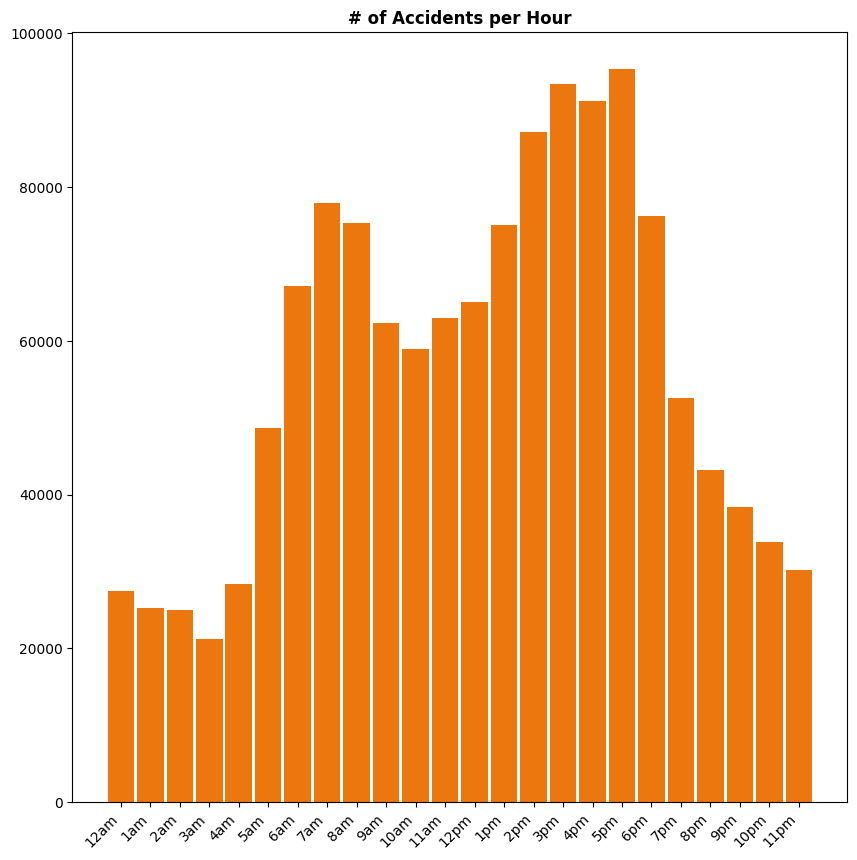

In [ ]:
zip_accident_df['Hour_String'] = zip_accident_df['Hour_Time'].apply(hour_to_regular_time)

hour_order = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
              '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

zip_accident_df['Hour_String'] = pd.Categorical(zip_accident_df['Hour_String'], categories = hour_order, ordered = True)
hour_counts = zip_accident_df['Hour_String'].value_counts().reindex(hour_order)

plt.figure(figsize = (10,10))
plt.bar(hour_counts.index, hour_counts.values, width = 0.9, color = '#ec770f')
plt.xticks(rotation=45, ha='right')
plt.title('# of Accidents per Hour', fontweight = 'bold')

plt.show()

Most accidents occur right before rush hour traffic in the morning (6am - 8am) and afternoon (2pm - 5pm). This aligns with when most people are driving, either to or from work. 

/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/1603257659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rush_hour_df['Hour_Time'] = rush_hour_df['Hour_Time'].apply(hour_to_regular_time)


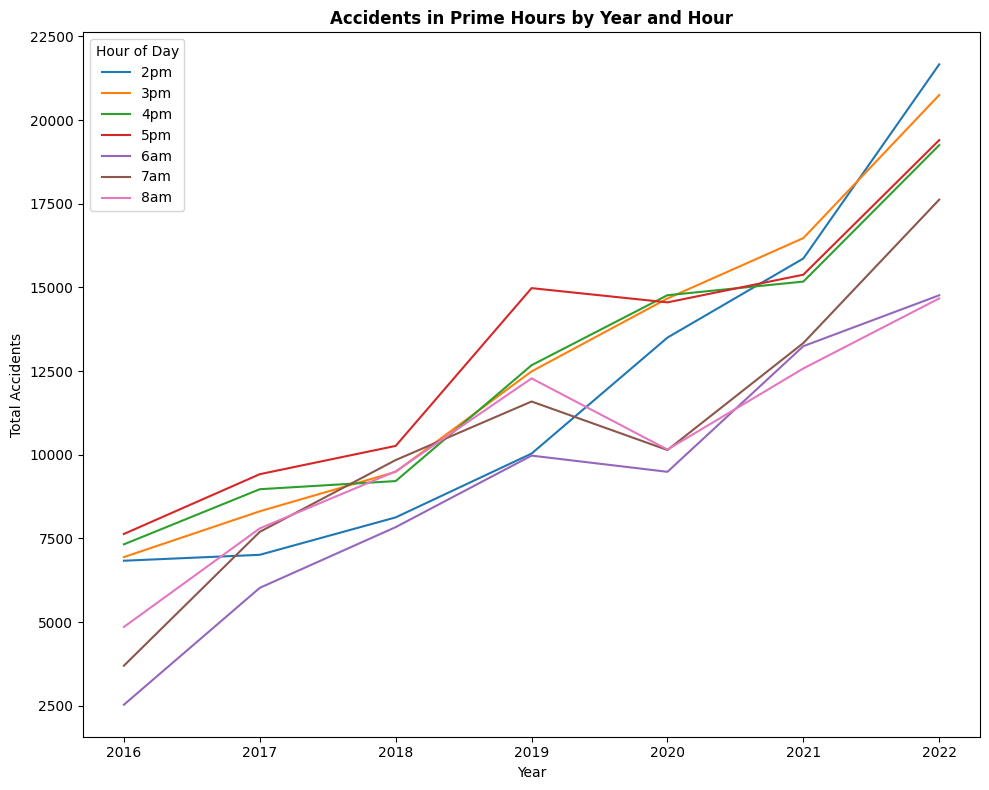

In [12]:
rush_hour_time_list = ['06', '07', '08', '14', '15', '16', '17']
rush_hour_df = zip_accident_df.query(' (Hour_Time.isin(@rush_hour_time_list)) and Year != "2023" ')
rush_hour_df['Hour_Time'] = rush_hour_df['Hour_Time'].apply(hour_to_regular_time)

hour_year_df_group = rush_hour_df.groupby(by = ['Year', 'Hour_Time'])['ID'].count().reset_index().rename(columns = {'ID': 'total_accidents'})

pivot_df = hour_year_df_group.pivot(values = 'total_accidents', index = 'Year', columns = 'Hour_Time')

pivot_df.plot(figsize = (10,8))
plt.title('Accidents in Prime Hours by Year and Hour', fontweight = 'bold')
plt.xlabel('Year')
plt.ylabel('Total Accidents')
plt.legend(title = 'Hour of Day', loc = 'upper left')
plt.tight_layout()
plt.show()

2023 is left out because the data only goes up to March 2023, meaning there will be less accidents for that year, skewing this line graph by showing a downward line for that year. 

There is an upward trend in the number of accidents that occur during peak accident hours year over year. Even with a dip in some hours during COVID lockdown, the number of accidents bounced back up in less 1-2 years and there has been no decrease since 2020.

/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/1506277237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rush_hour_df['Hour_Time'] = rush_hour_df['Hour_Time'].apply(hour_to_regular_time)
/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/1506277237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonrush_hour_df['Hour_Time'] = nonrush_hour_df['Hour_Time'].apply(hour_to_regular_time)


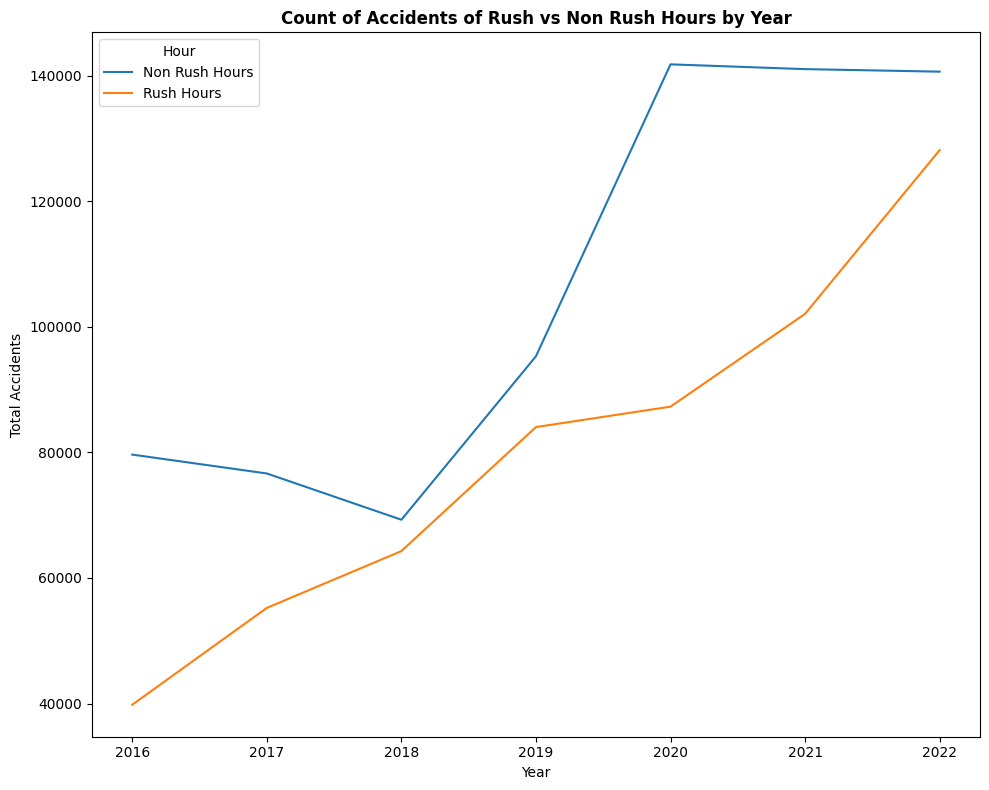

In [13]:
rush_hour_df = zip_accident_df.query(' (Hour_Time.isin(@rush_hour_time_list)) and Year != "2023" ')
rush_hour_df['Hour_Time'] = rush_hour_df['Hour_Time'].apply(hour_to_regular_time)

nonrush_hour_df = zip_accident_df.query(' (~Hour_Time.isin(@rush_hour_time_list)) and Year != "2023" ') 
nonrush_hour_df['Hour_Time'] = nonrush_hour_df['Hour_Time'].apply(hour_to_regular_time)

rush_hour_group_df = rush_hour_df.groupby(by = 'Year')['ID'].count().reset_index().rename(columns = {'ID': 'total_accidents'})
nonrush_hour_group_df = nonrush_hour_df.groupby(by = 'Year')['ID'].count().reset_index().rename(columns = {'ID': 'total_accidents'})

rush_hour_group_df['hours'] = 'Rush Hours'
nonrush_hour_group_df['hours'] = 'Non Rush Hours'

append_hour_df = pd.concat([rush_hour_group_df, nonrush_hour_group_df])

pivot_hour_df = append_hour_df.pivot(values = 'total_accidents', index = 'Year', columns = 'hours')

pivot_hour_df.plot(figsize = (10,8))
plt.title('Count of Accidents of Rush vs Non Rush Hours by Year', fontweight = 'bold')
plt.xlabel('Year')
plt.ylabel('Total Accidents')
plt.legend(title = 'Hour', loc = 'upper left')
plt.tight_layout()

plt.show()

Even though the non rush hour count of accidents are higher in terms of absolute value, there are years where there is yoy decline. From 2016 to 2018 (2 years) and 2020 to 2022 (2 years) totaling 4 years of decline out of 6. Number of accidents in non rush hours haven't recovered from their all time high in 2020. Comparing that to the rush hour times, accidents are slowly but surely increasing yoy. 

In [15]:
weather_df = zip_accident_df[['Severity', 'Visibility(mi)', 'Precipitation(in)', 'Weather_Condition']]

weather_df = weather_sentiment_func(
    weather_df, 
    weather_col = 'Weather_Condition',
    visibility_col = 'Visibility(mi)',
    precipitation_col = 'Precipitation(in)',
    weather_func = custom_weather_sentiment,
    visibility_func = custom_visibilty_sentiment,
    precipitation_func = custom_precipitation_sentiment
)

/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[weather_col] = df[weather_col].apply(weather_func)
/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[visibility_col] = df[weather_col].apply(visibility_func)
/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:242: SettingWithCopyWarning: 
A value is trying to be set on a co

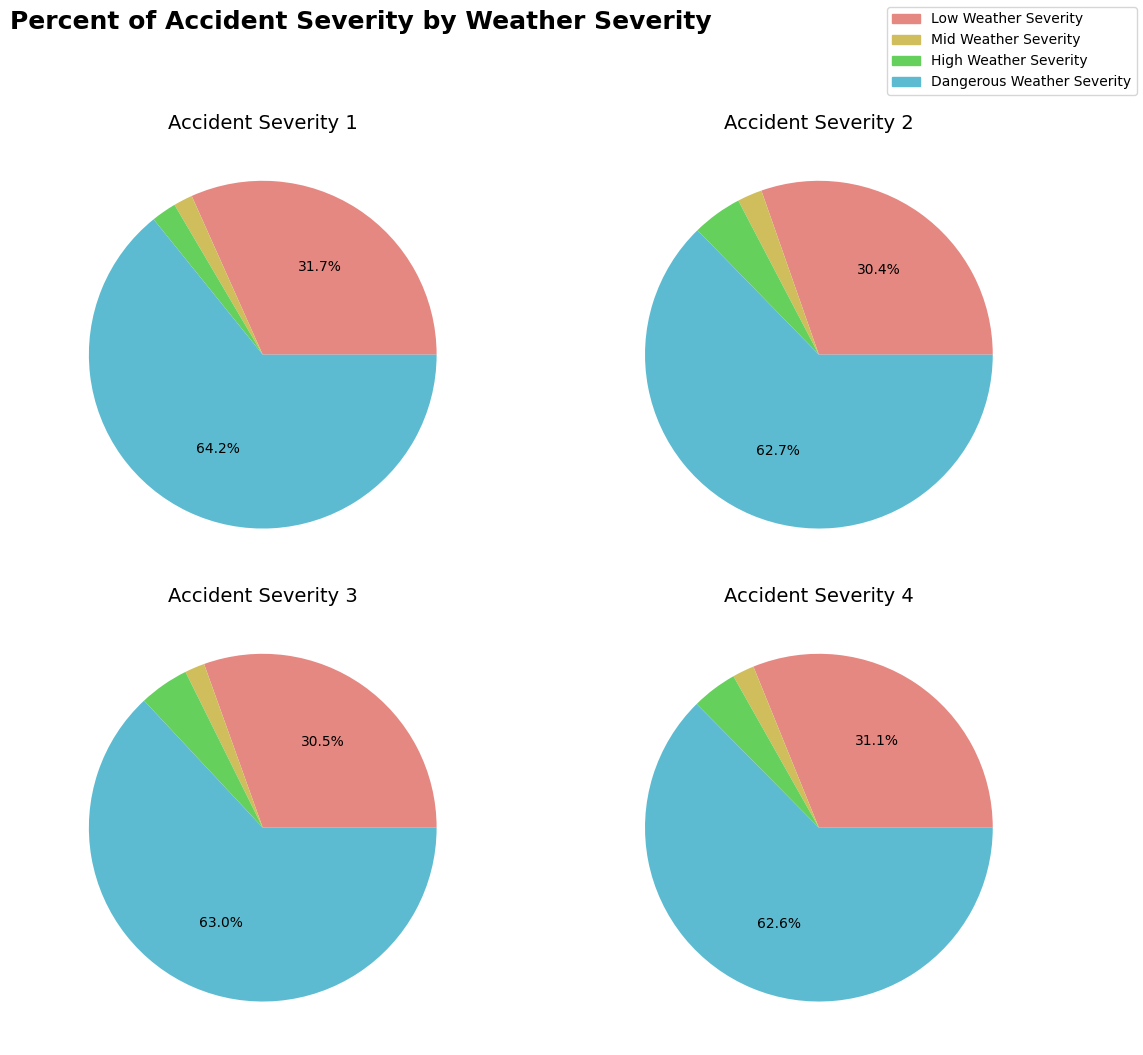

In [16]:
weather_df_melt = weather_df.melt(id_vars = 'Severity', var_name = 'Weather').groupby(by = ['Severity', 'value'])['value'].count().reset_index(name = 'cnt')

severity_1 = weather_df_melt.query(' Severity == 1 ')[['value', 'cnt']]
severity_2 = weather_df_melt.query(' Severity == 2 ')[['value', 'cnt']]
severity_3 = weather_df_melt.query(' Severity == 3 ')[['value', 'cnt']]
severity_4 = weather_df_melt.query(' Severity == 4 ')[['value', 'cnt']]


def plot_group_pie(ax, dataframes, title):
    ax.pie(dataframes['cnt'], autopct = auto_pct_num, colors = ['#e58882', '#d0be5c', '#66d05c', '#5cbbd0'])
    ax.set_title(title, fontsize = '14')

def auto_pct_num(value):
    if value > 10:
        return f'{value:.1f}%'
    else:
        return ''
    
    
fig, axs = plt.subplots(2,2, figsize = (12,10))
plot_group_pie(axs[0,0], severity_1, 'Accident Severity 1')
plot_group_pie(axs[0,1], severity_2, 'Accident Severity 2')
plot_group_pie(axs[1,0], severity_3, 'Accident Severity 3')
plot_group_pie(axs[1,1], severity_4, 'Accident Severity 4')

fig.suptitle('Percent of Accident Severity by Weather Severity', fontsize = 18, fontweight = 'bold', y = 1.05, x = .35)

low_patch = mpatches.Patch(color='#e58882', label='Low Weather Severity')
mid_patch = mpatches.Patch(color='#d0be5c', label='Mid Weather Severity')
high_patch = mpatches.Patch(color='#66d05c', label='High Weather Severity')
dangerous_patch = mpatches.Patch(color='#5cbbd0', label='Dangerous Weather Severity')

fig.legend(handles=[low_patch, mid_patch, high_patch, dangerous_patch])
plt.tight_layout()

plt.show()

This graph shows 2 things
1) That regardless of the severity of the accident (even if it's low) that the weather severity is consistent across all accidents
2) Most accidents occur in dangerous weather conditions. This is indicated by having dangerous weather severity account for ~ 60% of all accidents.

In [17]:
weather_zip_df = zip_accident_df[['ID', 'zip_code', 'Severity', 'Start_Lat', 'End_Lat', 'City', 'Visibility(mi)', 'Precipitation(in)', 'Weather_Condition']]

weather_zip_df = weather_sentiment_func(
    weather_zip_df, 
    weather_col = 'Weather_Condition',
    visibility_col = 'Visibility(mi)',
    precipitation_col = 'Precipitation(in)',
    weather_func = custom_weather_sentiment,
    visibility_func = custom_visibilty_sentiment,
    precipitation_func = custom_precipitation_sentiment
)

weather_zip_df['bad_accident'] = weather_zip_df['Severity'] > 2
weather_zip_df['bad_weather'] = (weather_zip_df['Visibility(mi)'] + weather_zip_df['Precipitation(in)'] + weather_zip_df['Weather_Condition']) > 3
weather_zip_df['bad_weather_accident'] = weather_zip_df['bad_accident'] & weather_zip_df['bad_weather']

weather_zip_group_df = weather_zip_df.groupby(by = 'zip_code').agg(
    total_accidents = ('ID', 'count'),
    total_bad_accidents = ('bad_accident', 'sum'),
    total_bad_weather = ('bad_weather', 'sum'),
    total_bad_weather_accident = ('bad_weather_accident', 'sum')
).reset_index()

weather_zip_group_df['pct_bad_accidents'] = ((weather_zip_group_df['total_bad_accidents'] / weather_zip_group_df['total_accidents']) * 100).round(2)
weather_zip_group_df['pct_bad_weather'] = ((weather_zip_group_df['total_bad_weather'] / weather_zip_group_df['total_accidents']) * 100).round(2) 
weather_zip_group_df['pct_bad_weather_accident'] = ((weather_zip_group_df['total_bad_weather_accident'] / weather_zip_group_df['total_accidents']) * 100).round(2) 


weather_zip_head_df = weather_zip_group_df.sort_values(by = 'pct_bad_weather_accident', ascending = False).head(20)

/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[weather_col] = df[weather_col].apply(weather_func)
/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[visibility_col] = df[weather_col].apply(visibility_func)
/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3670951971.py:242: SettingWithCopyWarning: 
A value is trying to be set on a co

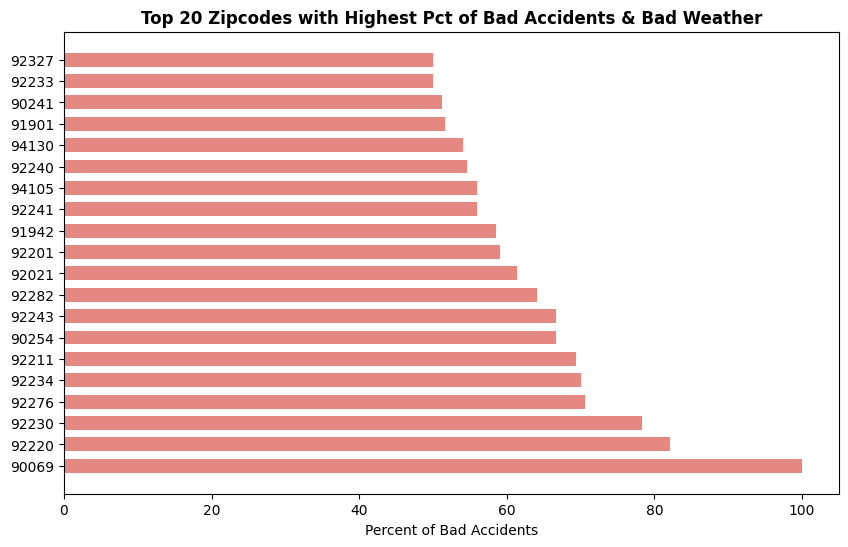

In [19]:
x = weather_zip_head_df['pct_bad_weather_accident']
y = weather_zip_head_df['zip_code']

plt.figure(figsize = (10,6))
plt.barh(y, x, color = '#e58882', height = 0.65)
plt.xlabel('Percent of Bad Accidents')
plt.title('Top 20 Zipcodes with Highest Pct of Bad Accidents & Bad Weather', fontweight = 'bold')

plt.show()

Zip codes with the highest percentage of bad accident & weather severity (as defined by severity above 1).

We have concluded that population size, commute times (6am - 8am and 2pm - 5pm), and weather severity all contribute to the number of accidents that occur. Next we will find the zip codes have a high likelihood to cause accidents based on the 3 aforementioned conditions. 

In [20]:
hour_df = acs_df

hour_df = hour_df.astype(int)
hour_df.rename(columns = {'B08011_002E': 'num_12am-4am', 'B01001_001E': 'population', 'B08006_002E': 'car_commuters'}, inplace = True)

hour_df['num_5am'] = hour_df['B08011_003E'] + hour_df['B08011_004E']
hour_df['num_6am'] = hour_df['B08011_005E'] + hour_df['B08011_006E']
hour_df['num_7am'] = hour_df['B08011_007E'] + hour_df['B08011_008E']
hour_df['num_8am'] = hour_df['B08011_009E'] + hour_df['B08011_010E']
hour_df['num_9am'] = hour_df['B08011_011E']
hour_df['num_10am'] = hour_df['B08011_012E']
hour_df['num_11am'] = hour_df['B08011_013E'] 
hour_df['num_12pm-4pm'] = hour_df['B08011_014E']
hour_df['num_5pm-11pm'] = hour_df['B08011_015E']
hour_df['cnt_accidents'] = hour_df['B08011_005E'] + hour_df['B08011_006E'] + hour_df['B08011_007E'] + hour_df['B08011_008E'] + hour_df['B08011_009E'] + hour_df['B08011_010E'] + hour_df['B08011_014E'] + hour_df['B08011_015E']

list_car_owners = ['B08014_003E', 'B08014_004E', 'B08014_005E', 'B08014_006E', 'B08014_007E']
hour_df['car_owners'] = hour_df[list_car_owners].sum(axis = 1)

hour_df = hour_df.sort_values(['zcta', 'year'], ascending = [True, True])
hour_df = hour_df[['year', 'zcta', 'population', 'cnt_accidents', 'car_owners', 'car_commuters']]
hour_df.replace(0, 1, inplace = True)

/var/folders/_d/ck_82j6x2vx7b1w6jlm_5cjr0000gn/T/ipykernel_782/3457362089.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_accident_rush_hour['Hour_Str'] = zip_accident_rush_hour['Hour_Time'].apply(hour_to_regular_time)


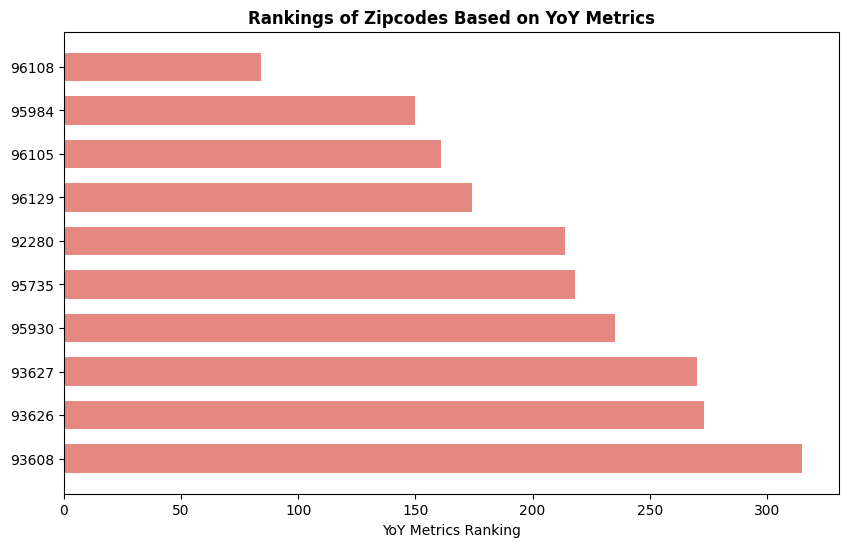

In [ ]:
# Dataframe for yoy growth of population, car owners, commuters with cars, and commuters during rush hours per zipcode 
pct_hour_df = hour_df.groupby(by = 'zcta')[['population', 'cnt_accidents', 'car_owners', 'car_commuters']].pct_change().mul(100)
pct_hour_df = pct_hour_df.replace([np.inf, -np.inf], 0)
pct_hour_df = pd.merge(hour_df, pct_hour_df, left_index = True, right_index = True)

pct_hour_df_group = pct_hour_df.groupby(by = 'zcta').agg(
    {
    'population_y': 'mean', 
    'cnt_accidents_y': 'mean',
    'car_owners_y': 'mean',
    'car_commuters_y': 'mean',
     }
    ).reset_index().rename(columns = 
                           {'population_y': 'population_yoy', 
                            'cnt_accidents_y': 'drivers_yoy',
                            'car_owners_y': 'car_owner_yoy',
                            'car_commuters_y': 'car_commuter_yoy'}
                           )

yoy_cols = ['drivers_yoy', 'population_yoy', 'car_owner_yoy', 'car_commuter_yoy']
pct_hour_df_group[yoy_cols] = pct_hour_df_group[yoy_cols].round(2)
pct_hour_df_group['zcta'] = pct_hour_df_group['zcta'].astype(str)

pct_zip = pd.merge(pct_hour_df_group, zip_zcta_df[['zip_code', 'zcta']], on = 'zcta')

# Dataframe for yoy growth of accidents per zipcode 
zip_accident_rush_hour = zip_accident_df.query(' Hour_Time.isin(@rush_hour_time_list) ')
zip_accident_rush_hour['Hour_Str'] = zip_accident_rush_hour['Hour_Time'].apply(hour_to_regular_time)

zip_accident_rush_group = zip_accident_rush_hour.groupby(by = ['Year', 'zip_code'])['ID'].count().reset_index().rename(columns = {'ID': 'total_accidents'})
zip_accident_rush_group.sort_values(by = ['zip_code', 'Year'], ascending = [True, True], inplace = True)

zip_accident_rush_pct = zip_accident_rush_group.groupby(by = 'zip_code')['total_accidents'].pct_change()
zip_accident_rush_merge = pd.merge(zip_accident_rush_pct, zip_accident_rush_group, left_index = True, right_index = True)
pct_zip_df = zip_accident_rush_merge.groupby(by = 'zip_code').agg({'total_accidents_x': 'mean'}).reset_index().rename(columns = {'total_accidents_x': 'accident_yoy'})
pct_zip_df['accident_yoy'] = pct_zip_df['accident_yoy'].mul(100).round(2)

yoy_cols.append('accident_yoy')

pct_zip_total = pd.merge(pct_zip, pct_zip_df, on = 'zip_code')

pct_zip_total = pct_zip_total.drop('zcta', axis = 1)
pct_zip_total['accident_yoy'] = pct_zip_total['accident_yoy'].fillna(0)


yoy_cols_rn = ['rn_' + x for x in yoy_cols]

for yoy in yoy_cols:
    pct_zip_total = row_num(pct_zip_total, yoy, ascending = False)

pct_zip_total['rank'] = pct_zip_total[yoy_cols_rn].sum(axis = 1)
pct_zip_total_sort = pct_zip_total.sort_values(by = 'rank')

pct_zip_total_rnk = row_num(pct_zip_total_sort, 'rank', ascending = True)
pct_zip_t0tal_rnk_head = pct_zip_total_rnk.head(10).sort_values(by = 'rank', ascending = False)
pct_zip_total_rnk
x = pct_zip_t0tal_rnk_head['rank']
y = pct_zip_t0tal_rnk_head['zip_code']

plt.figure(figsize = (10,6))
plt.barh(y, x, color = '#e58882', height = 0.65)
plt.xlabel('YoY Metrics Ranking')
plt.title('Rankings of Zipcodes Based on YoY Metrics', fontweight = 'bold')

plt.show()

In [ ]:
geolocator = Nominatim(user_agent = 'zipcode_geocoder')

def zip_lat_long(zip_code):
    location = geolocator.geocode(zip_code)
    
    if location:
        return [location.latitude, location.longitude]
    else:
        return None


zip_codes_list = weather_zip_group_df.sort_values(by = 'pct_bad_weather_accident', ascending = False).head(10)['zip_code'].to_list()
top_zip_lat_long = []
no_zip_list = []

for zip_codes in zip_codes_list:
    try: 
        lat_long_list = zip_lat_long(zip_codes)
        lat_long_list.append(zip_codes)
        
        top_zip_lat_long.append(lat_long_list)
        
        time.sleep(1)
    except:
        no_zip_list.append(zip_codes)


lat_long_df = pd.DataFrame(top_zip_lat_long, columns = ['lat', 'long', 'zip_code'])
lat_long_df.to_csv('data/lat_long/lat_long.csv', index = False)
print(no_zip_list)

[]


In [22]:
lat_long_df = pd.read_csv('data/lat_long/lat_long.csv')
lat_long_dict = lat_long_df.set_index('lat')['long'].to_dict()

In [23]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
today = date.today() 
end_date = today - dt.timedelta(days = 2)
end_date_str = str(end_date)
start_date = today - dt.timedelta(days = 730)
start_date_str = str(start_date)

empty_lat_long_list = []

for lat, long in lat_long_dict.items():
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": start_date,
		"end_date": end_date_str,
		"daily": ["rain_sum", "snowfall_sum"],
		"temperature_unit": "fahrenheit",
		"wind_speed_unit": "mph",
		"precipitation_unit": "inch",
		"timezone": "GMT"
	}
	responses = openmeteo.weather_api(url, params = params)

	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]

	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_rain_sum = daily.Variables(0).ValuesAsNumpy()
	daily_snowfall_sum = daily.Variables(1).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
	)}
	daily_data["rain_sum"] = daily_rain_sum
	daily_data["snowfall_sum"] = daily_snowfall_sum
	daily_data['lat'] = lat
	daily_data['long'] = long
  
	daily_dataframe = pd.DataFrame(data = daily_data)
	empty_lat_long_list.append(daily_dataframe)
 
	time.sleep(.2)

combined_lat_long_df = pd.concat(empty_lat_long_list)
combined_lat_long_df.to_csv('data/lat_long/lat_long_weather.csv', index = False)

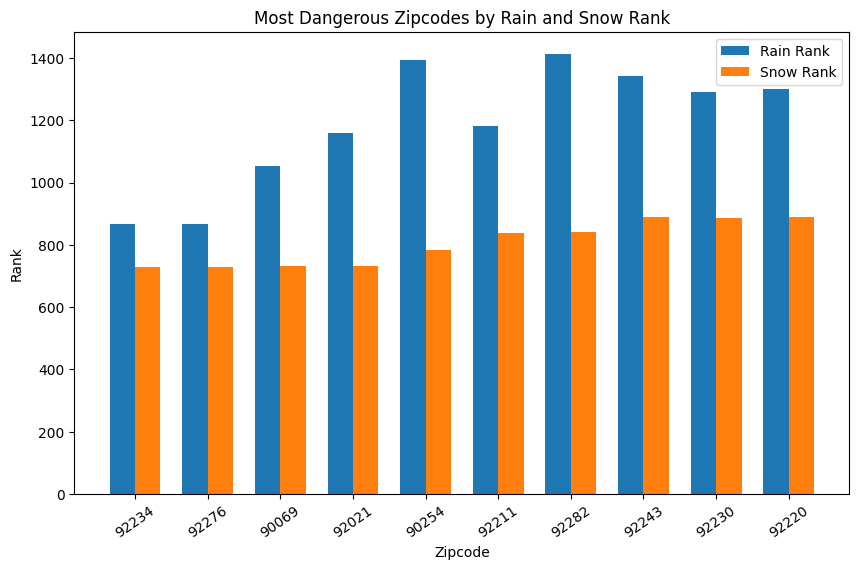

In [39]:
lat_long_weather = pd.read_csv('data/lat_long/lat_long_weather.csv')
lat_long_df = pd.read_csv('data/lat_long/lat_long.csv')

lat_long_weather['rain_rnk'] = lat_long_weather['rain_sum'].apply(custom_precipitation_sentiment)
lat_long_weather['snowfall_rnk'] = lat_long_weather['snowfall_sum'].apply(custom_snow_sentiment)

lat_long_group_df = lat_long_weather.groupby(by = ['lat', 'long']).agg({'rain_rnk': 'sum', 'snowfall_rnk': 'sum'}).reset_index()
merge_lat_long_zip = lat_long_group_df.merge(lat_long_df, on = ['lat', 'long'])

zip_codes_group = merge_lat_long_zip['zip_code']
rain_rnk = merge_lat_long_zip['rain_rnk']
snow_rnk = merge_lat_long_zip['snowfall_rnk']

fig, ax = plt.subplots(figsize = (10,6))
bar_width = 0.35

x = np.arange(len(zip_codes_group))

ax.bar(x - bar_width/2, rain_rnk, bar_width, label = 'Rain Rank')
ax.bar(x + bar_width/2, snow_rnk, bar_width, label = 'Snow Rank')

ax.set_xlabel('Zipcode')
ax.set_ylabel('Rank')
ax.set_title('Most Dangerous Zipcodes by Rain and Snow Rank')
ax.set_xticks(x)
ax.set_xticklabels(zip_codes_group, rotation = 35)
ax.legend()


plt.show()